## Importing Required Libraries
First, the necessary libraries are imported:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pynq import Overlay
import pynq.lib.dma
from pynq import allocate
import time

## Plotting Function
A function named plot_to_notebook is defined to plot the signals:

In [2]:
def plot_to_notebook (time_sec, in_signal, n_samples, out_signal=None):
    plt.figure()
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec [:n_samples]*1e6, in_signal [:n_samples], 'y')
#     if out_signal is not None:
#         plt.plot(time_sec[:n_samples]*1e6, out_signal [:n_samples], 'g-', linewidth=2, label='FIR output')
#     plt.legend()

## Signal and Carrier Generation
Parameters for the signals are set, and the time array is created:

In [3]:
T = 0.002
fs=100e6
Am=100
Ac=100
fm=0.2e6
fc=6e6
n = int(T*fs)
t = np.linspace(0,T,n,endpoint=False)

In [4]:
signal=Am*np.sin (2*np. pi*fm*t)
carrier=Ac*np.cos (2*np. pi*fc*t)
signal=signal.astype (np.int32)
carrier=carrier.astype (np.int32)

## Loading the Overlay and DMA Setup
The hardware overlay is loaded, and DMA channels are configured:

In [5]:
# Load the overlay
ol = Overlay("am.bit")
# Load the FIR DMA
dma0 = ol.axi_dma_0
dma0_send = ol.axi_dma_0.sendchannel
dma0_recv = ol.axi_dma_0.recvchannel
dma1 = ol.axi_dma_1
dma1_send = ol.axi_dma_1.sendchannel
dma1_recv = ol.axi_dma_1.recvchannel

hls_ip = ol.am_accel_0

## Configuring the HLS IP Core
The High-Level Synthesis (HLS) IP core is configured:

In [6]:
hls_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0)
}

In [7]:
CONTROL_REGISTER = 0x0
hls_ip.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0

In [8]:
hls_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0)
}

## Allocating Buffers and Transferring Data
Buffers are allocated for the signals and the output:

In [9]:
signal_buffer= allocate(shape=(n,),
                           dtype=np.int32)

carrier_buffer=allocate(shape=(n,),
                           dtype=np.int32)
out_buffer = allocate(shape=(n,),
                            dtype=np.int32)

for i in range(n):
    signal_buffer[i]=signal[i]
for i in range(n):
    carrier_buffer[i]=carrier[i]


Data is transferred between the buffers and the FPGA:

In [10]:
dma0_send.transfer(signal_buffer)
dma1_send.transfer(carrier_buffer)
dma0_recv.transfer(out_buffer)

## Plotting the Signals
Finally, the signals are plotted:

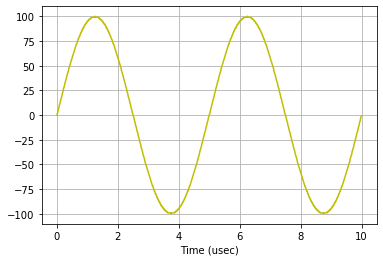

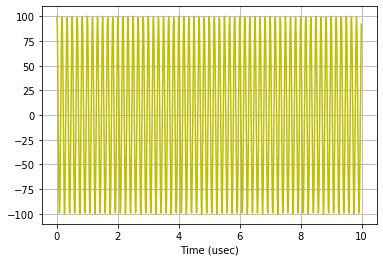

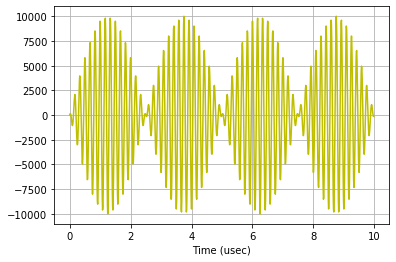

In [11]:
plot_to_notebook (t, signal_buffer, 1000)
plot_to_notebook (t, carrier_buffer, 1000)
plot_to_notebook (t, out_buffer, 1000)

## Cleanup
The buffers are deleted to free up memory:

In [12]:

del signal_buffer
del carrier_buffer
del out_buffer